# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## 1. Import Dependencies

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt

## 2. Data Preprocessing

In [3]:
data1 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="y", index_col=0)
data2 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x1", index_col=0)
data3 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x2", index_col=0)
data4 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x3", index_col=0)

y = np.array(data1)
x1 = np.array(data2)
x2 = np.array(data3)
x3 = np.array(data4)

data1_flat = data1.values.flatten()
data2_flat = data2.values.flatten()
data3_flat = data3.values.flatten()
data4_flat = data4.values.flatten()

In [4]:
data = pd.DataFrame({
    'y': data1_flat,
    'x1': data2_flat,
    'x2': data3_flat,
    'x3': data4_flat
})
data

,y,x1,x2,x3
0,17.080000,-1.970,7.73,0.334000
1,10.530000,4.990,6.39,0.336000
2,7.310000,5.625,5.99,0.342000
3,8.420000,-1.035,6.72,0.364000
4,8.860000,4.555,2.73,0.361000
...,...,...,...,...
607,11.636808,5.675,2.27,0.361471
608,16.256020,4.650,6.31,0.282647
609,6.512500,21.560,4.31,0.311061
610,20.156875,4.790,5.38,0.370000


## 3. Descriptive Stats

In [5]:
desc_stat = data.describe()
desc_stat

,y,x1,x2,x3
count,612.000000,612.000000,612.000000,612.000000
mean,10.771365,4.553186,5.030539,0.352567
std,5.609865,4.048237,1.788318,0.040239
min,3.420000,-21.300000,0.880000,0.236000
25%,6.377500,3.530000,3.697500,0.324000
50%,9.035000,5.030000,4.655000,0.351000
75%,13.805000,5.765000,6.162500,0.381000
max,28.540000,25.860000,10.950000,0.459000


In [9]:
writer = pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter')
with pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter') as writer:
    data.to_excel(writer, sheet_name='data', index=False)
    desc_stat.to_excel(writer, sheet_name='desc_stat')

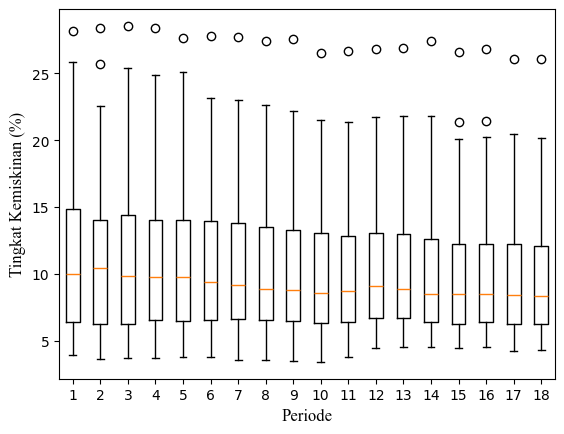

In [6]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data1.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Kemiskinan (%)', fontdict=font_prop)
plt.show()

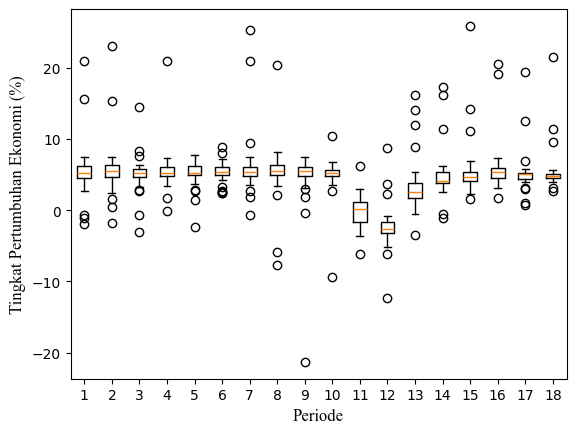

In [7]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data2.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Pertumbuhan Ekonomi (%)', fontdict=font_prop)
plt.show()

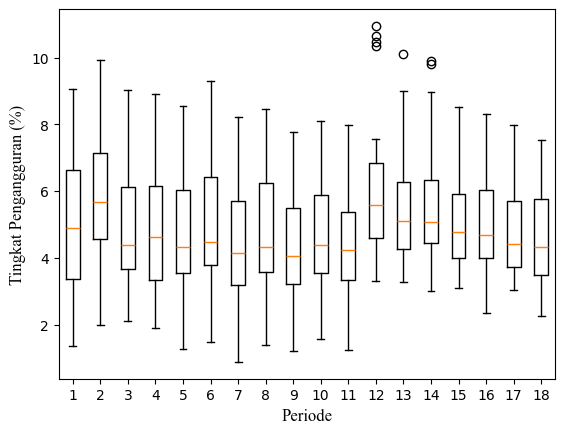

In [8]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data3.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Pengangguran (%)', fontdict=font_prop)
plt.show()

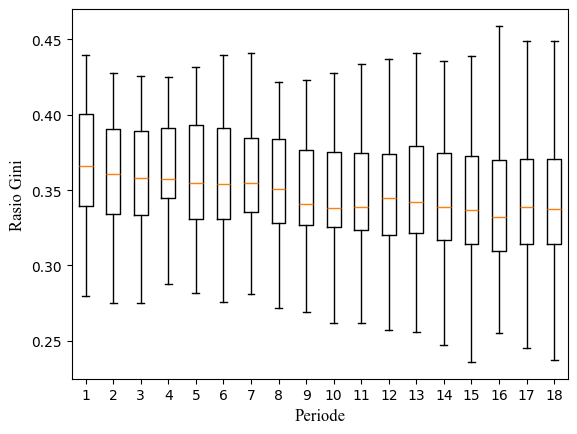

In [10]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data4.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Rasio Gini', fontdict=font_prop)
plt.show()

## 4. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

In [17]:
import statsmodels.api as sm

# Perform ADF test
adf_test = sm.tsa.adfuller(data4_flat)

# Extracting the results
adf_statistic = adf_test[0]
p_value = adf_test[1]
used_lag = adf_test[2]
n_obs = adf_test[3]
critical_values = adf_test[4]
aic_value = adf_test[5]

# Printing the results with labels
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print(f"Number of Lags Used: {used_lag}")
print(f"Number of Observations Used: {n_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}: {value}")
print(f"AIC Value: {aic_value}")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.772954263742686
p-value: 6.124907236888e-05
Number of Lags Used: 18
Number of Observations Used: 559
Critical Values:
    1%: -3.442102384299813
    5%: -2.8667242618524233
    10%: -2.569531046591633
AIC Value: -2390.2334307351575


## 6. Min-max Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def standardize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = standardize_data(data2_flat.reshape(-1,1))
x2_norm, x2_scaler = standardize_data(data3_flat.reshape(-1,1))
x3_norm, x3_scaler = standardize_data(data4_flat.reshape(-1,1))

## 7. Data Splitting

In [11]:
N_FEATURES = 3
SPLIT_TIME = 476
data_train = data[:SPLIT_TIME]
data_test = data[SPLIT_TIME:]
train_set = tf.data.Dataset.from_tensor_slices(data_train)
test_set = tf.data.Dataset.from_tensor_slices(data_test)

## 8. Neural Network Architecture

In [ ]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node, replication):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(3,)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset, callbacks=[early_stopping])
        if __name__ == '__main__':
                model.save(f"model_x{data_index}_{replication}_{hidden_node}.h5")
        train_loss = history.history['loss'][-1]
        test_loss = history.history['val_loss'][-1]
        train_epoch = len(history.epoch)
        weights = model.get_weights()
        return train_loss, test_loss, train_epoch, weights[0], weights[1], weights[2], weights[3]

In [ ]:
model_sum = pd.DataFrame(columns=['replication', 'hidden_node', 'train_mse', 'test_mse', 'epoch', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
    for rep in range(1, 6):
        iterasi = (rep - 1) * 20 + 1
        for n in range(1, 21):
            a,b,c,d,e,f,g = modelling(train_dataset=train_set, 
                                    test_dataset=test_set,
                                    epoch=50, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=n,
                                    replication=rep)
            idx = iterasi + n
            model_sum.loc[idx] = [rep,n,a,b,c,d,e,f,g]
    model_sum.to_excel(f'main_model_summary.xlsx')               